[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/dl/05_entrenamiento.ipynb)

# Entrenando Redes Neuronales

## Conjuntos de datos

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"].values.astype(np.float32), mnist["target"].values.astype(int)

In [2]:
import torch

class Dataset(torch.utils.data.Dataset):

	# constructor
	def __init__(self, X, Y):
		self.X = torch.tensor(X).float()
		self.Y = torch.tensor(Y).long()

	# cantidad de muestras en el dataset
	def __len__(self):
		return len(self.X)

	# devolvemos el elemento `ix` del dataset
	def __getitem__(self, ix):
		return self.X[ix], self.Y[ix]

In [3]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def train(model, epochs = 30, batch_size=1000, log_each = 10):
	dataset = Dataset(X, Y)
	dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
	model.cuda()
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters())
	l, acc = [], []
	for e in range(1, epochs+1):
		_l, _acc = [], []
		# entrenamiento
		model.train()
		for batch_ix, (x, y) in enumerate(dataloader):
			x, y = x.cuda(), y.cuda()
			optimizer.zero_grad()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				y_pred = model(x)
				loss = criterion(y_pred, y)
			_l.append(loss.item())
			y_probas = torch.argmax(softmax(y_pred), axis=1)
			_acc.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().detach().numpy()))
			loss.backward()
			optimizer.step()
		l.append(np.mean(_l))
		acc.append(np.mean(_acc))
		loss, current = loss.item(), (batch_ix + 1) * len(x)
		if e % log_each == 0:
			print(f"epoch: {e}/{epochs} loss: {loss:.4f} acc {acc[-1]:.5f}")
	return {'epoch': list(range(1, epochs+1)), 'loss': l,  'acc': acc}

In [4]:
from torch.nn import Sequential as S
from torch.nn import Linear as L
from torch.nn import ReLU as R

def build_model(H=128):
    return S(L(784,H),R(),L(H,10))

In [5]:
model = build_model()

hist = train(model, log_each=1)

epoch: 1/30 loss: 0.4487 acc 0.81359
epoch: 2/30 loss: 0.2073 acc 0.91893
epoch: 3/30 loss: 0.2475 acc 0.94064
epoch: 4/30 loss: 0.1509 acc 0.95330
epoch: 5/30 loss: 0.1149 acc 0.96090
epoch: 6/30 loss: 0.1248 acc 0.96837
epoch: 7/30 loss: 0.0801 acc 0.97373
epoch: 8/30 loss: 0.0828 acc 0.97726
epoch: 9/30 loss: 0.1040 acc 0.97983
epoch: 10/30 loss: 0.0527 acc 0.98243
epoch: 11/30 loss: 0.0413 acc 0.98510
epoch: 12/30 loss: 0.0476 acc 0.98716
epoch: 13/30 loss: 0.0595 acc 0.98843
epoch: 14/30 loss: 0.0350 acc 0.98983
epoch: 15/30 loss: 0.0346 acc 0.99089
epoch: 16/30 loss: 0.0462 acc 0.99246
epoch: 17/30 loss: 0.0233 acc 0.99329
epoch: 18/30 loss: 0.0262 acc 0.99326
epoch: 19/30 loss: 0.0257 acc 0.99470
epoch: 20/30 loss: 0.0496 acc 0.99490
epoch: 21/30 loss: 0.0118 acc 0.99550
epoch: 22/30 loss: 0.0170 acc 0.99601
epoch: 23/30 loss: 0.0129 acc 0.99683
epoch: 24/30 loss: 0.0129 acc 0.99791
epoch: 25/30 loss: 0.0064 acc 0.99860
epoch: 26/30 loss: 0.0079 acc 0.99859
epoch: 27/30 loss: 0.

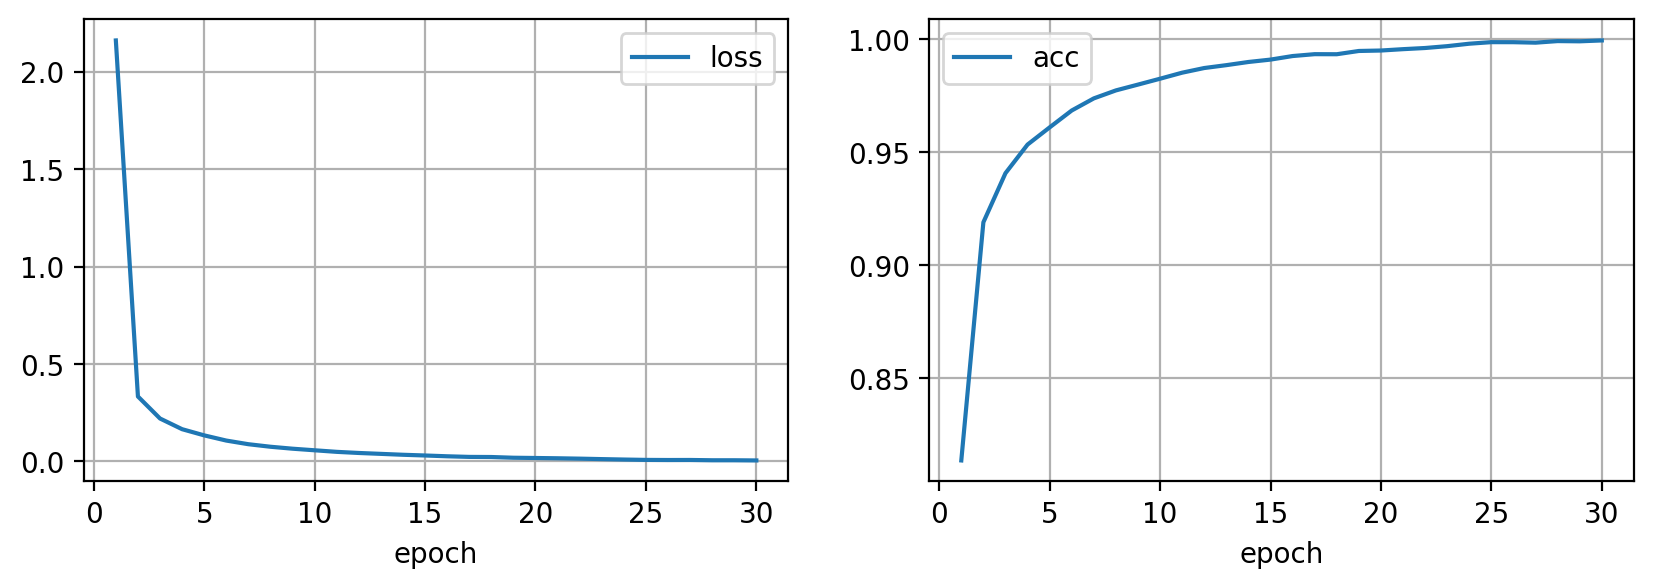

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y='loss', grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y='acc', grid=True, ax=ax)
plt.show()

El conjunto de validación

In [8]:
def train(model, epochs = 30, batch_size=1000, dataloader = None, log_each = 10, optimizer = None, scheduler=None):
	if dataloader is None:
		dataset = {
			"train": Dataset(X[:60000], Y[:60000]), # 60.000 imágenes para entrenamiento
			"val": Dataset(X[60000:], Y[60000:])    # 10.000 imágenes para validación
		}
		dataloader = {
			'train': torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
			'val': torch.utils.data.DataLoader(dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True)
		}
	model.cuda()
	criterion = torch.nn.CrossEntropyLoss()
	if optimizer is None:
		optimizer = torch.optim.Adam(model.parameters())
	l, acc, lr = [], [], []
	val_l, val_acc = [], []
	for e in range(1, epochs+1):
		_l, _acc = [], []
		for param_group in optimizer.param_groups:
			lr.append(param_group['lr'])
		# entrenamiento
		model.train()
		for batch_ix, (x, y) in enumerate(dataloader['train']):
			x, y = x.cuda(), y.cuda()
			optimizer.zero_grad()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				y_pred = model(x)
				loss = criterion(y_pred, y)
			_l.append(loss.item())
			y_probas = torch.argmax(softmax(y_pred), axis=1)
			_acc.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().detach().numpy()))
			loss.backward()
			optimizer.step()
		l.append(np.mean(_l))
		acc.append(np.mean(_acc))
		loss, current = loss.item(), (batch_ix + 1) * len(x)
		# validación
		model.eval()
		_l, _acc = [], []
		with torch.no_grad():
			for batch_ix, (x, y) in enumerate(dataloader['val']):
				x, y = x.cuda(), y.cuda()
				with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
					y_pred = model(x)
					loss = criterion(y_pred, y)
					_l.append(loss.item())
					y_probas = torch.argmax(softmax(y_pred), axis=1)
					_acc.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().numpy()))
		val_l.append(np.mean(_l))
		val_acc.append(np.mean(_acc))
		if scheduler:
			scheduler.step()
		if e % log_each == 0:
			print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
	return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [9]:
model = build_model()
hist = train(model, log_each=1)

Epoch 1/30 loss 2.19903 acc 0.82018 val_loss 0.44493 val_acc 0.90600
Epoch 2/30 loss 0.33723 acc 0.92272 val_loss 0.29828 val_acc 0.92680
Epoch 3/30 loss 0.21416 acc 0.94332 val_loss 0.24127 val_acc 0.94030
Epoch 4/30 loss 0.15488 acc 0.95678 val_loss 0.21230 val_acc 0.94560
Epoch 5/30 loss 0.12073 acc 0.96525 val_loss 0.20011 val_acc 0.94690
Epoch 6/30 loss 0.09466 acc 0.97217 val_loss 0.18121 val_acc 0.95260
Epoch 7/30 loss 0.07807 acc 0.97622 val_loss 0.17409 val_acc 0.95390
Epoch 8/30 loss 0.06515 acc 0.98022 val_loss 0.17251 val_acc 0.95610
Epoch 9/30 loss 0.05235 acc 0.98380 val_loss 0.17164 val_acc 0.95640
Epoch 10/30 loss 0.04500 acc 0.98660 val_loss 0.16387 val_acc 0.95960
Epoch 11/30 loss 0.03792 acc 0.98843 val_loss 0.16398 val_acc 0.96040
Epoch 12/30 loss 0.03188 acc 0.98975 val_loss 0.16656 val_acc 0.96130
Epoch 13/30 loss 0.02694 acc 0.99207 val_loss 0.17146 val_acc 0.96180
Epoch 14/30 loss 0.02383 acc 0.99287 val_loss 0.16530 val_acc 0.96180
Epoch 15/30 loss 0.01894 acc 

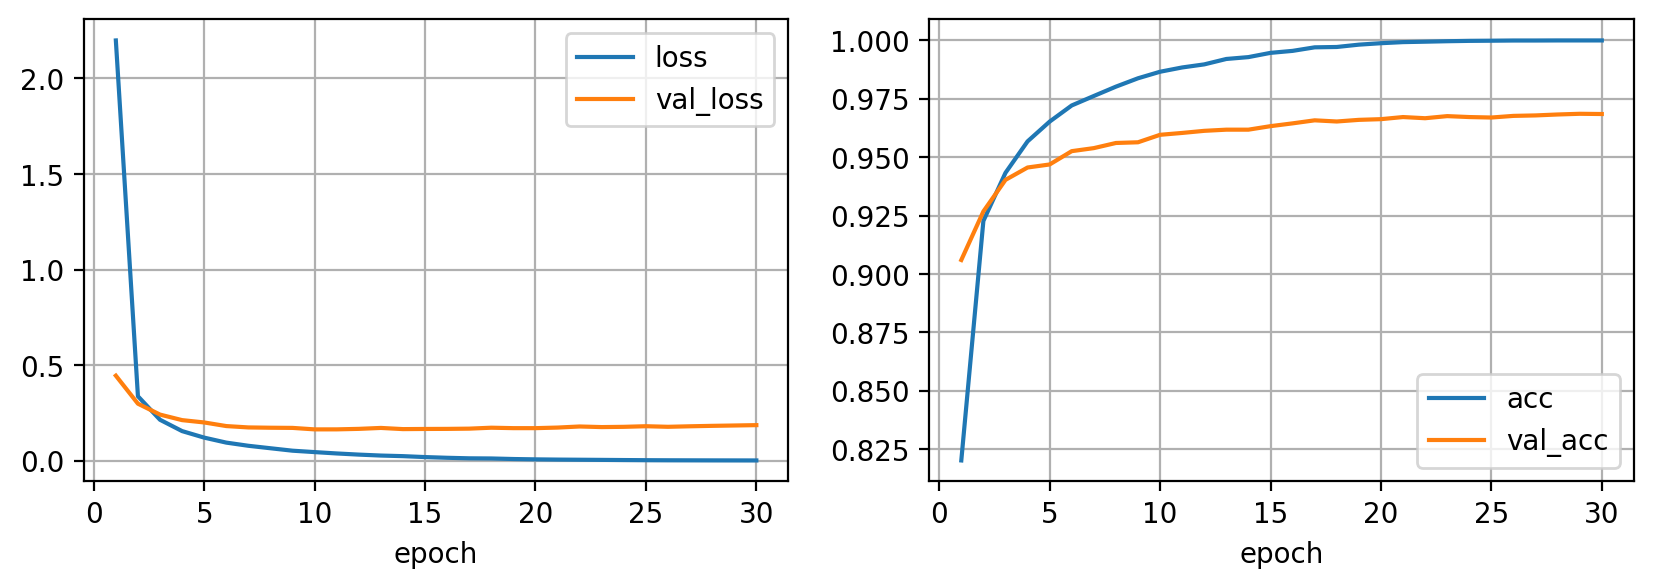

In [13]:
def plot_hist(hist):
    fig = plt.figure(dpi=200, figsize=(10,3))
    ax = plt.subplot(121)
    pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
    ax = plt.subplot(122)
    pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
    plt.show()

plot_hist(hist)

Capacidad del modelo

In [14]:
model = build_model(H=3)

hist = train(model, epochs=10, log_each=1)

Epoch 1/10 loss 2.81222 acc 0.10400 val_loss 2.35465 val_acc 0.10280
Epoch 2/10 loss 2.34597 acc 0.10442 val_loss 2.33969 val_acc 0.10280
Epoch 3/10 loss 2.33470 acc 0.10442 val_loss 2.33258 val_acc 0.10280
Epoch 4/10 loss 2.32562 acc 0.10442 val_loss 2.32395 val_acc 0.10280
Epoch 5/10 loss 2.31897 acc 0.10442 val_loss 2.31519 val_acc 0.10280
Epoch 6/10 loss 2.31366 acc 0.10442 val_loss 2.31285 val_acc 0.10280
Epoch 7/10 loss 2.30944 acc 0.10442 val_loss 2.31040 val_acc 0.10280
Epoch 8/10 loss 2.30730 acc 0.10442 val_loss 2.30348 val_acc 0.10280
Epoch 9/10 loss 2.30471 acc 0.10442 val_loss 2.30297 val_acc 0.10280
Epoch 10/10 loss 2.30445 acc 0.10442 val_loss 2.30382 val_acc 0.10280


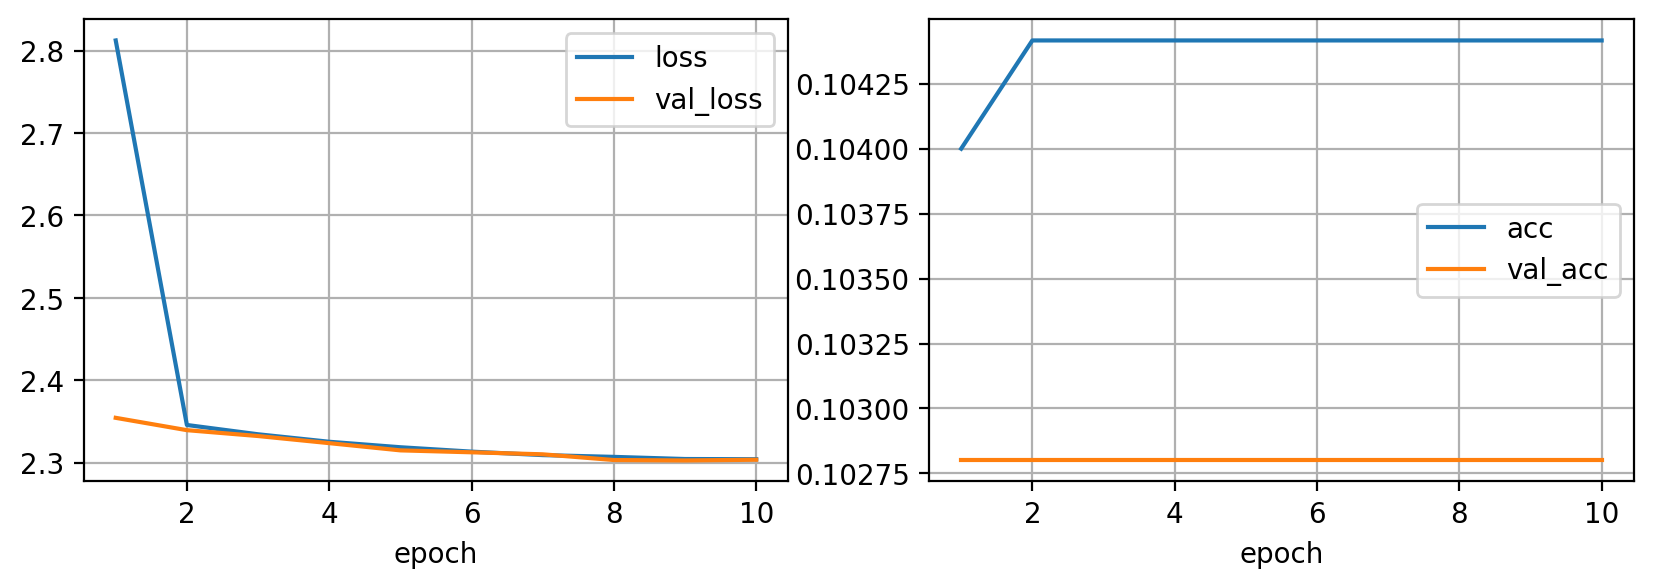

In [15]:
plot_hist(hist)

Validación cruzada

In [16]:
from sklearn.model_selection import KFold

FOLDS = 5
kf = KFold(n_splits=FOLDS)

# separamos en train y test
X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000], Y[60000:]

X_train.shape, X_test.shape, kf.get_n_splits(X)

((60000, 784), (10000, 784), 5)

In [17]:
train_accs, val_accs = [], []
models = []
# hacemos validación cruzada con datos de train
for k, (train_index, val_index) in enumerate(kf.split(X_train)):
    print("Fold:", k+1)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    dataset = {
        'train': Dataset(X_train_fold, y_train_fold),
        'val': Dataset(X_val_fold, y_val_fold)
    }
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    models.append(model)
    hist = train(model, dataloader=dataloader)
    train_accs.append(hist['acc'][-1])
    val_accs.append(hist['val_acc'][-1])

Fold: 1
Epoch 10/30 loss 0.03605 acc 0.99000 val_loss 0.08172 val_acc 0.97617
Epoch 20/30 loss 0.00603 acc 0.99923 val_loss 0.09462 val_acc 0.97633
Epoch 30/30 loss 0.00706 acc 0.99806 val_loss 0.10772 val_acc 0.97758
Fold: 2
Epoch 10/30 loss 0.03796 acc 0.98973 val_loss 0.09289 val_acc 0.97125
Epoch 20/30 loss 0.00735 acc 0.99881 val_loss 0.10024 val_acc 0.97383
Epoch 30/30 loss 0.00402 acc 0.99906 val_loss 0.11444 val_acc 0.97458
Fold: 3
Epoch 10/30 loss 0.03756 acc 0.98933 val_loss 0.09318 val_acc 0.97175
Epoch 20/30 loss 0.00691 acc 0.99879 val_loss 0.10214 val_acc 0.97350
Epoch 30/30 loss 0.00758 acc 0.99781 val_loss 0.12294 val_acc 0.97458
Fold: 4
Epoch 10/30 loss 0.03476 acc 0.99010 val_loss 0.10152 val_acc 0.97017
Epoch 20/30 loss 0.00656 acc 0.99902 val_loss 0.11420 val_acc 0.97125
Epoch 30/30 loss 0.00071 acc 1.00000 val_loss 0.13117 val_acc 0.97350
Fold: 5
Epoch 10/30 loss 0.03892 acc 0.98929 val_loss 0.08731 val_acc 0.97375
Epoch 20/30 loss 0.00720 acc 0.99877 val_loss 0.09

In [18]:
np.mean(train_accs), np.std(train_accs)

(0.9989791666666668, 0.0009175185435606895)

In [19]:
np.mean(val_accs), np.std(val_accs)

(0.9755333333333333, 0.001654623152798799)

El conjunto de test

In [20]:
dataset = { 'test': Dataset(X_test, y_test) }
dataloader = { 'test': torch.utils.data.DataLoader(dataset['test'], batch_size=100) }
test_accs = []
with torch.no_grad():
	for model in models:
		model.eval()
		preds = torch.tensor([]).cuda()
		for batch_ix, (x, y) in enumerate(dataloader['test']):
			x, y = x.cuda(), y.cuda()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				y_pred = model(x)
				preds = torch.cat([preds, y_pred])
		preds = torch.mean(preds, axis=0)	
		y_probas = torch.argmax(softmax(y_pred), axis=1)
		test_accs.append(accuracy_score(y.cpu().numpy(), y_probas.cpu().numpy()))

np.mean(test_accs), np.std(test_accs)

(0.982, 0.011661903789690611)

## Optimización

In [21]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.25126 acc 0.93213 val_loss 0.29088 val_acc 0.92490
Epoch 20/30 loss 0.16636 acc 0.95325 val_loss 0.22654 val_acc 0.94090
Epoch 30/30 loss 0.12810 acc 0.96293 val_loss 0.20082 val_acc 0.94690


In [22]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.14680 acc 0.95623 val_loss 0.17489 val_acc 0.94710
Epoch 20/30 loss 0.10139 acc 0.96957 val_loss 0.14493 val_acc 0.95700
Epoch 30/30 loss 0.07769 acc 0.97708 val_loss 0.13857 val_acc 0.96230


In [23]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.16192 acc 0.95355 val_loss 0.19640 val_acc 0.95240
Epoch 20/30 loss 0.33085 acc 0.95032 val_loss 0.16879 val_acc 0.96240
Epoch 30/30 loss 0.02514 acc 0.99193 val_loss 0.18367 val_acc 0.96450


In [24]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = train(model, optimizer=optimizer)

Epoch 10/30 loss 0.06867 acc 0.97923 val_loss 0.20082 val_acc 0.95420
Epoch 20/30 loss 0.01865 acc 0.99533 val_loss 0.19370 val_acc 0.96200
Epoch 30/30 loss 0.00540 acc 0.99940 val_loss 0.20568 val_acc 0.96290


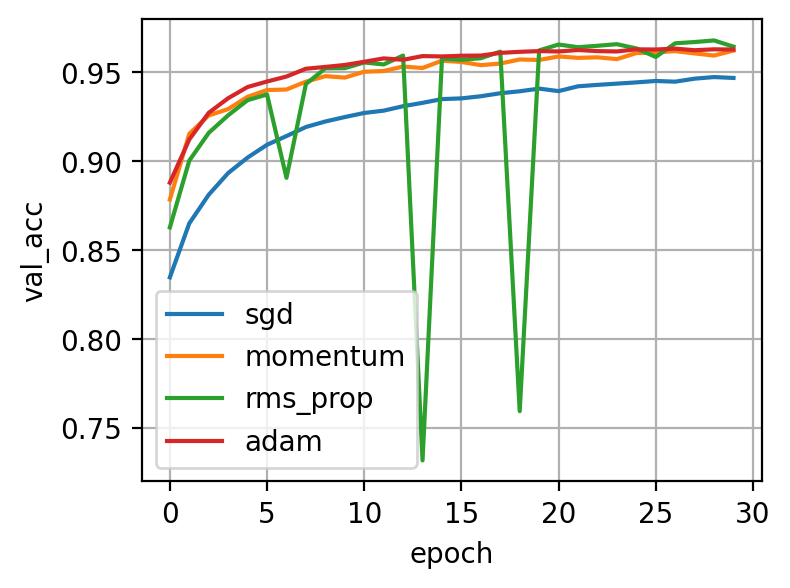

In [25]:
fig = plt.figure(dpi=200, figsize=(4,3))
ax = plt.subplot(111)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('val_acc')
ax.set_xlabel('epoch')
plt.show()

## Transfer Learning

In [1]:
import wget

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers (1).zip'

In [2]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
import os

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['tulip', 'dandelion', 'rose', 'sunflower', 'daisy']

In [4]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: tulip. Imágenes: 984
Categoría: dandelion. Imágenes: 1055
Categoría: rose. Imágenes: 784
Categoría: sunflower. Imágenes: 734
Categoría: daisy. Imágenes: 769


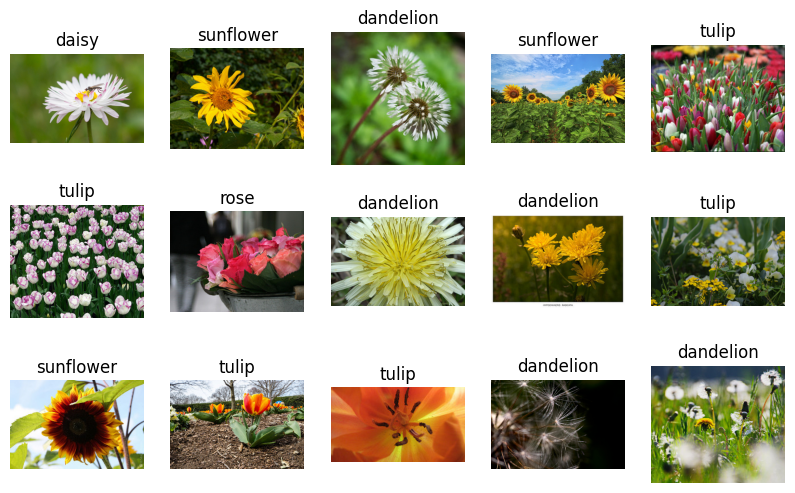

In [5]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imagen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [8]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

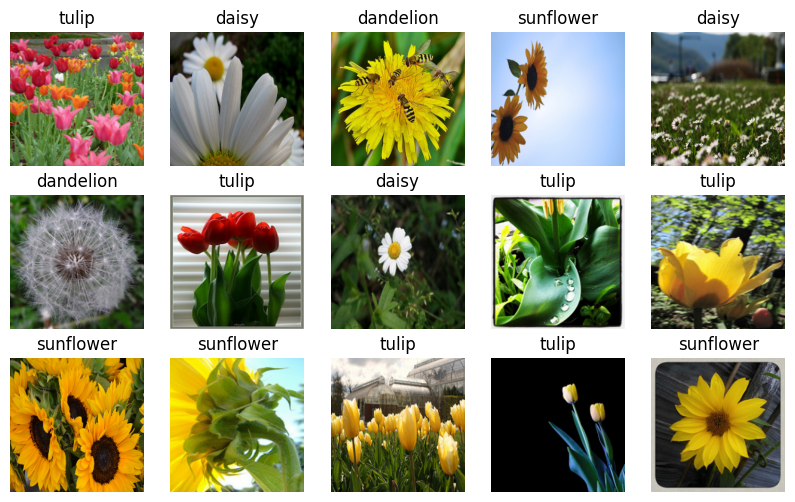

In [9]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [10]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [11]:
import torchvision

resnet = torchvision.models.resnet18()

In [12]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, n_outputs)
    self.freeze = freeze

  def forward(self, x):
    if self.freeze:
      with torch.no_grad():
        x = self.resnet(x)
    else:
      x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    self.freeze = False
    for param in self.resnet.parameters():
        param.requires_grad=True

In [13]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [14]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [15]:
model = Model()
fit(model, dataloader, epochs=15)

val_loss 1.55262 val_acc 0.34544: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Epoch 1/15 loss 1.36404 val_loss 1.55262 acc 0.40767 val_acc 0.34544


val_loss 1.49975 val_acc 0.38610: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 2/15 loss 1.13691 val_loss 1.49975 acc 0.54545 val_acc 0.38610


val_loss 2.37912 val_acc 0.33603: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 3/15 loss 1.02629 val_loss 2.37912 acc 0.59801 val_acc 0.33603


val_loss 1.77862 val_acc 0.44258: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 4/15 loss 0.96347 val_loss 1.77862 acc 0.62386 val_acc 0.44258


val_loss 33.50848 val_acc 0.21799: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 5/15 loss 0.92299 val_loss 33.50848 acc 0.65114 val_acc 0.21799


val_loss 2.48600 val_acc 0.32626: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 6/15 loss 0.93814 val_loss 2.48600 acc 0.64290 val_acc 0.32626


val_loss 1.13676 val_acc 0.57917: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 7/15 loss 0.84660 val_loss 1.13676 acc 0.68494 val_acc 0.57917


val_loss 2.95990 val_acc 0.33665: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 8/15 loss 0.77974 val_loss 2.95990 acc 0.69688 val_acc 0.33665


val_loss 13.35223 val_acc 0.16854: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 9/15 loss 0.78652 val_loss 13.35223 acc 0.69176 val_acc 0.16854


loss 0.96501 acc 0.65820:  15%|█▍        | 8/55 [00:03<00:19,  2.45it/s]

In [ ]:
model = Model(pretrained=True, freeze=True)

fit(model, dataloader)

In [ ]:
model = Model(pretrained=True, freeze=False)

fit(model, dataloader)

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

In [ ]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

## Regularización

In [ ]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

In [ ]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader)

In [ ]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

L2

In [ ]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Early Stopping

In [ ]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()


Dropout

In [ ]:
def build_model(D_in=32*32*3, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [ ]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Más datos

In [ ]:
# ahora sí que usamos todos los datos

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

In [ ]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Data augmentation

In [ ]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 0
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = trainset[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

In [ ]:
model = build_model()
hist = fit(model, dataloader)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()